# LSTM CNN. Пробная модель.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 28, 64)    │      1,216 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 14, 64)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 30, 50)    │     11,400 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 896)       │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 25)        │      7,600 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 896)       │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 25)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 921)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20)        │     18,440 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 20)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         21 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,677 (151.08 KB)

 Trainable params: 38,677 (151.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8576 - auc: 0.8713 - loss: 4.2369 - val_accuracy: 0.9892 - val_auc: 0.9947 - val_loss: 0.0562
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9769 - auc: 0.9851 - loss: 0.2522 - val_accuracy: 0.9901 - val_auc: 0.9997 - val_loss: 0.0214
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9790 - auc: 0.9958 - loss: 0.0717 - val_accuracy: 0.9911 - val_auc: 0.9997 - val_loss: 0.0255
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9873 - auc: 0.9992 - loss: 0.0332 - val_accuracy: 0.9911 - val_auc: 0.9998 - val_loss: 0.0264
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9846 - auc: 0.9972 - loss: 0.0564 - val_accuracy: 0.9878 - val_auc: 0.9998 - val_loss: 0.0188
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9845 - auc: 0.9978 - loss: 0.0413 - val_accuracy: 0.9948 - val_auc: 0.9999 - val_loss: 0.0137
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/

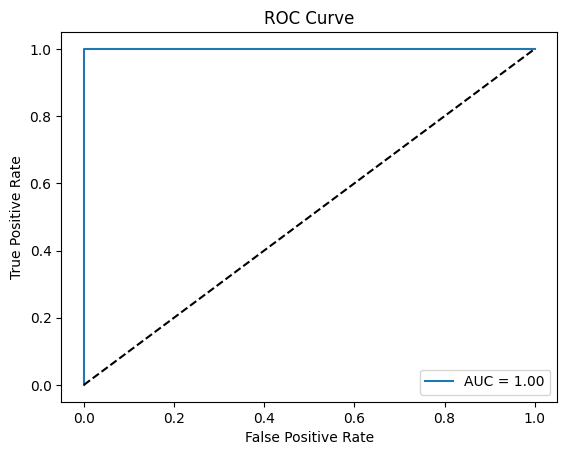

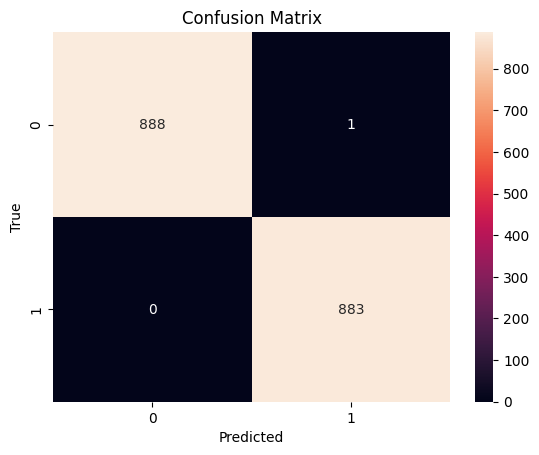

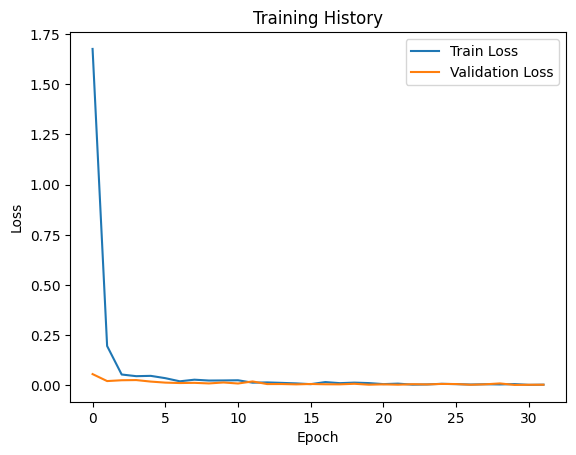

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, f1_score, 
                             confusion_matrix, roc_curve, auc)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, Conv1D, 
                                   MaxPooling1D, Flatten, concatenate, Dropout)
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import joblib

data_path = r'D:\Проекты\Дипломаня работа\DoFitN\Code\DoFitN\data\New_data.csv'
model_dir = r'D:\Проекты\Дипломаня работа\DoFitN\Code\DoFitN\main\model'

df = pd.read_csv(data_path)

# Кодирование категориальных переменных
cat_cols = ['sender_mac', 'sender_ip', 'target_mac', 'target_ip']
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Сохранение LabelEncoders
label_encoders_path = os.path.join(model_dir, 'label_encoders.pkl')
joblib.dump(label_encoders, label_encoders_path)

# Нормализация числовых переменных
scaler = StandardScaler()
num_cols = ['timestamp', 'operation']
df[num_cols] = scaler.fit_transform(df[num_cols])

# Сохранение Scaler
scaler_path = os.path.join(model_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)

# Создание временных окон
def create_sequences(data, window_size):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
    return np.array(X)

window_size = 30  # Размер временного окна
X = create_sequences(df.drop('label', axis=1).values, window_size)
y = df['label'].values[window_size:]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели
def create_model(input_shape):
    cnn_input = Input(shape=input_shape)
    cnn = Conv1D(64, 3, activation='relu')(cnn_input)
    cnn = MaxPooling1D(2)(cnn)
    cnn = Flatten()(cnn)
    cnn = Dropout(0.3)(cnn)  #

    lstm = LSTM(50, return_sequences=True)(cnn_input)
    lstm = LSTM(25)(lstm)
    lstm = Dropout(0.3)(lstm) 

    merged = concatenate([cnn, lstm])

    dense = Dense(20, activation='relu')(merged)
    dense = Dropout(0.3)(dense)  
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=cnn_input, outputs=output)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', 
                           tf.keras.metrics.AUC(name='auc')])
    return model

model = create_model((window_size, X_train.shape[2]))
model.summary()

# Обучение модели
early_stop = EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.3,
                    callbacks=[early_stop])

# Оценка модели
y_pred = model.predict(X_test).ravel()
y_pred_class = (y_pred > 0.5).astype(int)

print(f"AUC: {roc_auc_score(y_test, y_pred):.3f}")
print(f"F1-Score: {f1_score(y_test, y_pred_class):.3f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Графики обучения
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Сохранение модели
model_path = os.path.join(model_dir, 'arp_spoofing_detection_model.h5')
model.save(model_path)

In [ ]:
from sklearn.metrics import classification_report

y_train_pred = model.predict(X_train).ravel()
y_train_pred_class = (y_train_pred > 0.5).astype(int)

y_test_pred = model.predict(X_test).ravel()
y_test_pred_class = (y_test_pred > 0.5).astype(int)

print("=== TRAIN METRICS ===")
print(f"AUC: {roc_auc_score(y_train, y_train_pred):.3f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred_class):.3f}")
print(classification_report(y_train, y_train_pred_class))

print("\n=== TEST METRICS ===")
print(f"AUC: {roc_auc_score(y_test, y_test_pred):.3f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred_class):.3f}")
print(classification_report(y_test, y_test_pred_class))
